In this notebook we tried to predcit the Industry column which were marked as 'Others'. We have performed model train and test on augmented data due to very small dataset.

Pickle from the best performing model is used for final model pipeline.

# Load Libraries

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Setting the current working directory
import os; os.chdir('/content/drive/MyDrive/Colab Notebooks/Capstone')

In [ ]:
# Import packages
import warnings; warnings.filterwarnings('ignore')
import pandas as pd, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt, seaborn as sns
import matplotlib.style as style

import random, re
assert tf.__version__ >= '2.0'
%matplotlib inline

# Text preprocessing and stopwords
from text_preprocess import * #(custom module)

# Models
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Set random state
random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

!rm -R log/

#Lable Encoder to change the categorical values to numerical values.
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
rm: cannot remove 'log/': No such file or directory


# Load Data

## Load augmented data
* This is augmented due to limited dataset which was provided.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Capstone/IHMStefanini_industrial_safety_and_health_database_with_accidents_description_Dataset.csv')

#data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Capstone/cat_train.csv')
#val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Capstone/cat_val.csv')
print(f'Data has {data.shape[0]} rows and {data.shape[1]} columns. Here are the first five rows of the data...')
display(data)

Data has 425 rows and 11 columns. Here are the first five rows of the data...


,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
1,1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...
2,2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...
3,3,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...
4,4,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...
...,...,...,...,...,...,...,...,...,...,...,...
420,434,2017-07-04 00:00:00,Country_01,Local_04,Mining,I,III,Male,Third Party,Others,"Being approximately 5:00 a.m. approximately, w..."
421,435,2017-07-04 00:00:00,Country_01,Local_03,Mining,I,II,Female,Employee,Others,The collaborator moved from the infrastructure...
422,436,2017-07-05 00:00:00,Country_02,Local_09,Metals,I,II,Male,Employee,Venomous Animals,During the environmental monitoring activity i...
423,437,2017-07-06 00:00:00,Country_02,Local_05,Metals,I,II,Male,Employee,Cut,The Employee performed the activity of strippi...


In [ ]:
data_bkp = data.copy()

In [ ]:
print('Dropping Unnamed: 0 column')
data.drop(['Unnamed: 0'],axis =1,inplace = True)

Dropping Unnamed: 0 column


In [ ]:
data.rename(columns={'Data':'Date','Genre':'Gender','Industry Sector':'Industry','Accident Level':'Accident','Potential Accident Level':'Potential_Accident','Employee or Third Party':'Emp_Type','Critical Risk':'Critical Risk'},inplace=True)
data['SNo']= data.index+1

ind_map ={'Mining': 1,
'Metals': 2,
'Others': 9}
data['Industry'] = pd.Series([ind_map[x] for x in data['Industry']], index=data.index)

In [ ]:
print('Dropping duplicates')
#data.drop_duplicates(inplace=True)

Dropping duplicates


In [ ]:
data = data[['SNo','Description','Industry']]

In [ ]:
data

,SNo,Description,Industry
0,1,While removing the drill rod of the Jumbo 08 f...,1
1,2,During the activation of a sodium sulphide pum...,1
2,3,In the sub-station MILPO located at level +170...,1
3,4,Being 9:45 am. approximately in the Nv. 1880 C...,1
4,5,Approximately at 11:45 a.m. in circumstances t...,1
...,...,...,...
420,421,"Being approximately 5:00 a.m. approximately, w...",1
421,422,The collaborator moved from the infrastructure...,1
422,423,During the environmental monitoring activity i...,2
423,424,The Employee performed the activity of strippi...,2


In [ ]:
from text_preprocess import * #(custom module)
import re
def clean_text(df, col):
	print('--'*30); print('Converting headlines to lower case')
	new_col_name = "cleaned_" + str(col)
	print(new_col_name)
	df.new_col_name = df[col].apply(lambda x : x.lower())
	print(df.new_col_name[0])

	print('Replacing apostrophes to the standard lexicons')
	df.new_col_name = df.new_col_name.apply(lambda x : replace_words(x))

	print('Removing punctuations')
	df.new_col_name = df.new_col_name.apply(lambda x: remove_punctuation(x))

	print('Removing Numbers')
	df.new_col_name = df.new_col_name.apply(lambda x : ''.join([i for i in x if not i.isdigit()]))

	print('Applying Lemmatizer')
	df.new_col_name = df.new_col_name.apply(lambda x: lem(x))

	print('Removing multiple spaces between words')
	df.new_col_name = df.new_col_name.apply(lambda x: re.sub(' +', ' ', x))

	print('Removing stopwords')
	df.new_col_name = df.new_col_name.apply(lambda x: remove_stopwords(x))

	# remove short words (length < 3)
	print('Removing short words')
	df.new_col_name = df.new_col_name.apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
	print('--'*30)
	return(df.new_col_name)

In [ ]:
data['cleaned_Description'] = clean_text(data,"Description")

------------------------------------------------------------
Converting headlines to lower case
cleaned_Description
while removing the drill rod of the jumbo 08 for maintenance, the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal, seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this, at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo.
Replacing apostrophes to the standard lexicons
Removing punctuations
Removing Numbers
Applying Lemmatizer
Removing multiple spaces between words
Removing stopwords
Removing short words
------------------------------------------------------------


In [ ]:
# Get length of each line
data['line_length'] = data['cleaned_Description'].str.len()

print('Minimum line length: {}'.format(data['line_length'].min()))
print('Maximum line length: {}'.format(data['line_length'].max()))

Minimum line length: 62
Maximum line length: 656


In [ ]:
# Get length of each line
data['nb_words'] = data['cleaned_Description'].apply(lambda x: len(x.split(' ')))

print('Minimum number of words: {}'.format(data['nb_words'].min()))
print('Maximum number of words: {}'.format(data['nb_words'].max()))

Minimum number of words: 9
Maximum number of words: 93


## Others and Non-other category wise data split

In [ ]:
Test = data[data['Industry'] == 9].reset_index(drop=True)
Train = data[data['Industry'] != 9].reset_index(drop=True)

In [ ]:
Train

,SNo,Description,Industry,cleaned_Description,line_length,nb_words
0,1,While removing the drill rod of the Jumbo 08 f...,1,removing drill rod jumbo maintenance superviso...,276,37
1,2,During the activation of a sodium sulphide pum...,1,activation sodium sulphide pump piping uncoupl...,204,27
2,3,In the sub-station MILPO located at level +170...,1,substation milpo located level collaborator ex...,199,29
3,4,Being 9:45 am. approximately in the Nv. 1880 C...,1,approximately personnel begin task unlocking s...,337,45
4,5,Approximately at 11:45 a.m. in circumstances t...,1,approximately circumstance mechanic anthony gr...,293,39
...,...,...,...,...,...,...
370,421,"Being approximately 5:00 a.m. approximately, w...",1,approximately approximately lifting kelly towa...,130,17
371,422,The collaborator moved from the infrastructure...,1,collaborator moved infrastructure office julio...,150,22
372,423,During the environmental monitoring activity i...,2,environmental monitoring activity area employe...,151,21
373,424,The Employee performed the activity of strippi...,2,employee performed activity stripping cathode ...,132,19


In [ ]:
print(Train.shape)
print(Test.shape)

(375, 6)
(50, 6)


In [ ]:
Train.head()

,SNo,Description,Industry,cleaned_Description,line_length,nb_words
0,1,While removing the drill rod of the Jumbo 08 f...,1,removing drill rod jumbo maintenance superviso...,276,37
1,2,During the activation of a sodium sulphide pum...,1,activation sodium sulphide pump piping uncoupl...,204,27
2,3,In the sub-station MILPO located at level +170...,1,substation milpo located level collaborator ex...,199,29
3,4,Being 9:45 am. approximately in the Nv. 1880 C...,1,approximately personnel begin task unlocking s...,337,45
4,5,Approximately at 11:45 a.m. in circumstances t...,1,approximately circumstance mechanic anthony gr...,293,39


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    Train['cleaned_Description'].values, Train['Industry'].values, 
    test_size=0.2, random_state=0)
print('Training utterances: {}'.format(X_train.shape[0]))
print('Validation utterances: {}'.format(X_val.shape[0]))

#X_predict =without_risk_df['cleaned_Description'].values

Training utterances: 300
Validation utterances: 75


# Tokenizer and word embeddings

In [ ]:
max_features = 1000
maxlen = 100 #max(data.nb_words)
#embedding_size = 200

In [ ]:
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(X_train))
tokenizer.fit_on_texts(list(X_val))


In [ ]:
maxlen

100

## Text Train split

In [ ]:
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen = maxlen)
#y_Train = np.asarray(Train['Critical_Risk'])

X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val, maxlen = maxlen)


print(f'Number of Samples: {len(X_train)}')
print(f'Number of Labels: {len(y_train)}')
print(f'\nFirst Description:\n{X_train[0]}\n\nLabel of the first description: {y_train[0]}')

print(f'Number of Samples: {len(X_val)}')
print(f'Number of Labels: {len(y_val)}')
print(f'\nFirst Description:\n{X_val[0]}\n\nLabel of the first description: {y_val[0]}')

Number of Samples: 300
Number of Labels: 300

First Description:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0 866  30  51 867 161 328 448  58 528  59 868 328 869
  62 209  40 449 656 289  62 328  10  53   3   1 233 123 449  31 870 657
  34 256   3   1 108  12 378 234 257  49]

Label of the first description: 2
Number of Samples: 75
Number of Labels: 75

First Description:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0 524 670 119 560 860 156 388 666 524
 662   2 246 134   4   1 538 361 244 108]

Label of the first des

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(300, 100)
(300,)
(75, 100)
(75,)


In [ ]:
risk_data_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Capstone/IHMStefanini_industrial_safety_and_health_database_with_accidents_description_Dataset.csv')
risk_data_df.drop(['Unnamed: 0'],axis =1,inplace = True)
risk_data_df.rename(columns={'Data':'Date','Genre':'Gender','Industry Sector':'Industry','Accident Level':'Accident','Potential Accident Level':'Potential_Accident','Employee or Third Party':'Emp_Type','Critical Risk':'Critical Risk'},inplace=True)
#risk_data_df['Critical Risk'] = pd.Series([risk_map[x] for x in risk_data_df['Critical Risk']], index=risk_data_df.index)

risk_grade = {'Mining':1,'Metals':2,'Others':9}
risk_data_df['Industry'] = pd.Series([risk_grade[x] for x in risk_data_df['Industry']], index=risk_data_df.index)


# Others
without_ind_df = risk_data_df[risk_data_df['Industry'] == 9].reset_index(drop=True)

# Non-others where actual data was provided
with_ind_df = risk_data_df[risk_data_df['Industry'] != 9].reset_index(drop=True)

#with_risk_df.drop(columns = 'Critical_Risk',axis= 1, inplace=True)

In [ ]:
Test = data[data['Industry'] == 'Others'].reset_index(drop=True)

In [ ]:
# Hyper Parameter Tuning for full data
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


seed=42
pipe_steps = [ ('sc' , StandardScaler()),
    ('pca', PCA())]

check_params= {
    'pca__n_components': [45] 
   # 'RF__max_depth': [18,20,22]
    #'RF__n_estimators' :[300,500,900],
    #'RF__max_features' : [5,6],
    #'RF__ccp_alpha' : [0.05,0.1]
}
pca_pipeline = Pipeline(pipe_steps)

BR: 0.720000 (0.028674)
XGB: 0.740000 (0.022608)
RF: 0.750000 (0.027889)
CART: 0.686667 (0.052068)
GB: 0.753333 (0.049889)
SVM: 0.753333 (0.032318)


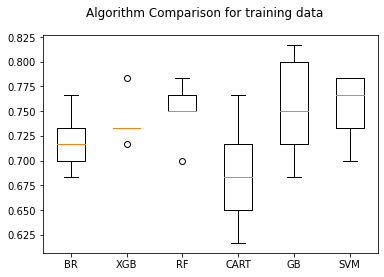

In [ ]:
# Compare Algorithms for full data
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb


x_train_tr=pca_pipeline.fit_transform(X_train)
# prepare configuration for cross validation test harness
seed = 42
# prepare models
models = []
models.append(('BR', BaggingClassifier()))
models.append(('XGB', xgb.XGBClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('SVM', SVC(kernel='rbf')))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=5, random_state=seed)
	cv_results = model_selection.cross_val_score(model, x_train_tr, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison for training data')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#PCA with SVM
## Standard scalar

In [ ]:
# Standarize features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_val_sc = sc.transform(X_val)

## PCA

In [ ]:
# Encode, standardize and PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

Components_Number = 45

pca = PCA(n_components = Components_Number , random_state = random_state, svd_solver = 'full', whiten = True)
pca.fit(X_train_sc)
X_train_pca = pca.transform(X_train_sc)
X_val_pca = pca.transform(X_val_sc)
display(X_train_pca.shape, X_val_pca.shape)
feature = X_train_pca.shape[1]
pca_s = sum(pca.explained_variance_ratio_)*100
print(f'Explained Variance: {pca_s:1.3f}% with {feature} features.')

(300, 45)

(75, 45)

Explained Variance: 97.421% with 45 features.


## SVC classifier fit/test

In [ ]:
from sklearn.svm import SVC

#svc_pca = SVC(kernel = 'rbf', class_weight = 'balanced', random_state = random_state)

svc_pca = SVC(kernel = 'rbf',C=10,gamma='scale', random_state = random_state)
svc_pca.fit(X_train_pca, y_train)
print('SVC accuracy for train set: {0:.3f}'.format(svc_pca.score(X_train_pca, y_train)))

SVC accuracy for train set: 0.967


In [ ]:
model = SVC()
param_grid = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}
svc_grid = GridSearchCV(SVC(),param_grid,refit = True, verbose=2)
svc_grid.fit(X_train_pca, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ...................... C=1, gamma=1, kernel=linear, total=   0.0s
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ...................... C=1, gamma=1, kernel=linear, total=   0.0s
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ...................... C=1, gamma=1, kernel=linear, total=   0.0s
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ...................... C=1, gamma=1, kernel=linear, total=   0.0s
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ...................... C=1, gamma=1, kernel=linear, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ..........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................. C=1, gamma=0.001, kernel=linear, total=   0.0s
[CV] C=1, gamma=0.001, kernel=linear .................................
[CV] .................. C=1, gamma=0.001, kernel=linear, total=   0.0s
[CV] C=1, gamma=0.001, kernel=linear .................................
[CV] .................. C=1, gamma=0.001, kernel=linear, total=   0.0s
[CV] C=1, gamma=0.001, kernel=linear .................................
[CV] .................. C=1, gamma=0.001, kernel=linear, total=   0.0s
[CV] C=1, gamma=0.001, kernel=linear .................................
[CV] .................. C=1, gamma=0.001, kernel=linear, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  3.9min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [ ]:
svc_grid.best_params_

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

In [ ]:
print('SVM accuracy for test set: {0:.3f}'.format(svc_grid.score(X_val_pca, y_val)))

SVM accuracy for test set: 0.587


# Performnce Tuning

In [ ]:
# example of grid searching key hyperparameters for RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# define dataset

# define models and parameters
model = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=random_state)
rf_grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0,verbose=2)
grid_result = rf_grid_search.fit(X_train_pca, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))



Fitting 30 folds for each of 6 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   33.8s


Best: 0.773333 using {'max_features': 'log2', 'n_estimators': 100}
0.736667 (0.068503) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.764444 (0.070937) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.768889 (0.068817) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.726667 (0.082282) with: {'max_features': 'log2', 'n_estimators': 10}
0.773333 (0.072214) with: {'max_features': 'log2', 'n_estimators': 100}
0.771111 (0.072384) with: {'max_features': 'log2', 'n_estimators': 1000}


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.4min finished


In [ ]:
print('RF accuracy for test set: {0:.3f}'.format(rf_grid_search.score(X_val_pca, y_val)))

RF accuracy for test set: 0.707


In [ ]:
# example of grid searching key hyperparameters for GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
# define dataset
# define models and parameters
model = GradientBoostingClassifier()
n_estimators = [10, 100, 1000]
learning_rate = [0.001, 0.01, 0.1]
subsample = [0.5, 0.7, 1.0]
max_depth = [3, 7, 9]
# define grid search
grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=random_state)
gb_grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0,verbose=2)
grid_result = gb_grid_search.fit(X_train_pca, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 6 folds for each of 81 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 414 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed:  4.2min finished


Best: 0.758889 using {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 1000, 'subsample': 0.5}
0.640000 (0.000000) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.5}
0.640000 (0.000000) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.7}
0.640000 (0.000000) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 1.0}
0.640000 (0.000000) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
0.640000 (0.000000) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
0.640000 (0.000000) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
0.735556 (0.017498) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.5}
0.745556 (0.027057) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.7}
0.730000 (0.026874) with: {'learning_rate': 0.001, '

In [ ]:
# example of grid searching key hyperparameters for BaggingClassifier

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
# define dataset
# define models and parameters
model = BaggingClassifier()
n_estimators = [10, 100, 1000]
# define grid search
grid = dict(n_estimators=n_estimators)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=random_state)
bg_grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0,verbose=2)
grid_result = bg_grid_search.fit(X_train_pca, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 30 folds for each of 3 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.8min finished


Best: 0.763333 using {'n_estimators': 1000}
0.724444 (0.072487) with: {'n_estimators': 10}
0.756667 (0.077531) with: {'n_estimators': 100}
0.763333 (0.079977) with: {'n_estimators': 1000}


In [ ]:
print('Bagging accuracy for test set: {0:.3f}'.format(bg_grid_search.score(X_val_pca, y_val)))

Bagging accuracy for test set: 0.693


## Validation/Test with augmented dataset

In [ ]:
# Predict
y_pred = svc_grid.predict(X_val_pca)

# Accuracy Score
print('Accuracy Score on Test: {}'.format(accuracy_score(y_val, y_pred).round(3)))

Accuracy Score on Test: 0.587


In [ ]:
#Random forest
# Predict
y_pred = rf_grid_search.predict(X_val_pca)

# Accuracy Score
print('Accuracy Score on Test: {}'.format(accuracy_score(y_val, y_pred).round(3)))

Accuracy Score on Test: 0.707


In [ ]:
#Gradient Boost
# Predict
y_pred = gb_grid_search.predict(X_val_pca)

# Accuracy Score
print('Accuracy Score on Test: {}'.format(accuracy_score(y_val, y_pred).round(3)))

Accuracy Score on Test: 0.693


In [ ]:
#Bagging
# Predict
y_pred = bg_grid_search.predict(X_val_pca)

# Accuracy Score
print('Accuracy Score on Test: {}'.format(accuracy_score(y_val, y_pred).round(3)))

Accuracy Score on Test: 0.693


In [ ]:
## LSTM

In [ ]:
import os
#os.chdir('/home/sunil/Desktop/Great Lakes')
import pickle
filename = 'predict_industry.pkl'
pickle.dump(rf_grid_search, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
print(loaded_model)
result = loaded_model.score(X_val_pca, y_val)
print(result) 

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=42),
             error_score=0,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                      

In [ ]:
from sklearn.externals import joblib
filename = 'finalized_model_joblib.sav'
joblib.dump(svc_pca, filename)

['finalized_model_joblib.sav']

In [ ]:
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, y_test)
print(result)

0.734375


# Predict risk where risk category was Others

In [ ]:
# get prediction  column cleaned data

X_predict =Test['cleaned_Description'].values
#tokenize
tokenizer.fit_on_texts(list(X_predict))
# to sequences
X_predict = tokenizer.texts_to_sequences(X_predict)
X_predict = pad_sequences(X_predict, maxlen = maxlen)

In [ ]:
# scalar
X_predict_sc = sc.transform(X_predict)
# pca
X_predict_pca = pca.transform(X_predict_sc)

In [ ]:
# Predict
y_pred = gb_grid_search.predict(X_predict_pca)

# Accuracy Score
#print('Accuracy Score on Test: {}'.format(accuracy_score(y_test, y_pred).round(3)))

In [ ]:
pd.DataFrame(y_pred).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       50 non-null     int64
dtypes: int64(1)
memory usage: 528.0 bytes


In [ ]:
y_pred

array([1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1])

# Concat predcted risk with the original dataframe 'Others' risk category

In [ ]:
Test.drop('Industry',axis = 1,inplace=True)
Test['Industry']= y_pred

In [ ]:
Test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   SNo                  50 non-null     int64 
 1   Description          50 non-null     object
 2   cleaned_Description  50 non-null     object
 3   line_length          50 non-null     int64 
 4   nb_words             50 non-null     int64 
 5   Industry             50 non-null     int64 
dtypes: int64(4), object(2)
memory usage: 2.5+ KB


In [ ]:
without_risk_df.drop(columns=['cleaned_Description'],axis=1,inplace=True)
without_risk_df

,Date,Countries,Local,Industry,Accident,Potential_Accident,Gender,Emp_Type,Description,Critical Risk
0,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Being 9:45 am. approximately in the Nv. 1880 C...,3
1,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Approximately at 11:45 a.m. in circumstances t...,11
2,2016-01-19 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Third Party (Remote),Employee was sitting in the resting area at le...,8
3,2016-01-28 00:00:00,Country_01,Local_03,Mining,I,III,Male,Employee,While installing a segment of the polyurethane...,3
4,2016-01-30 00:00:00,Country_01,Local_03,Mining,I,IV,Male,Third Party,While preparing the rice for the lunch of the ...,3
...,...,...,...,...,...,...,...,...,...,...
228,2017-06-23 00:00:00,Country_02,Local_05,Metals,I,II,Male,Employee,Employee reports that by removing the zinc she...,3
229,2017-06-19 00:00:00,Country_03,Local_10,Others,III,IV,Male,Third Party,During the execution of the task of assembling...,3
230,2017-06-22 00:00:00,Country_03,Local_10,Others,I,IV,Male,Employee,The technician was returning from his activiti...,3
231,2017-07-04 00:00:00,Country_01,Local_04,Mining,I,III,Male,Third Party,"Being approximately 5:00 a.m. approximately, w...",6


In [ ]:
with_risk_df

,Date,Countries,Local,Industry,Accident,Potential_Accident,Gender,Emp_Type,Critical Risk,Description
0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,8,While removing the drill rod of the Jumbo 08 f...
1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,8,During the activation of a sodium sulphide pum...
2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),3,In the sub-station MILPO located at level +170...
3,2016-01-12 00:00:00,Country_02,Local_05,Metals,I,III,Male,Third Party (Remote),8,During the unloading operation of the ustulado...
4,2016-01-16 00:00:00,Country_02,Local_05,Metals,I,III,Male,Employee,4,The collaborator reports that he was on street...
...,...,...,...,...,...,...,...,...,...,...
187,2017-06-22 00:00:00,Country_03,Local_10,Others,I,I,Male,Employee,1,"During the field activity in the AMG project, ..."
188,2017-06-29 00:00:00,Country_02,Local_02,Mining,I,III,Male,Employee,8,After maintenance on Boltec 03 at level 285 GT...
189,2017-07-05 00:00:00,Country_02,Local_09,Metals,I,II,Male,Employee,1,During the environmental monitoring activity i...
190,2017-07-06 00:00:00,Country_02,Local_05,Metals,I,II,Male,Employee,3,The Employee performed the activity of strippi...


# Append with and without dataframes

In [ ]:
final_industry_dataset = Train.append(Test,ignore_index=True)

In [ ]:
final_industry_dataset

,Date,Countries,Local,Industry,Accident,Potential_Accident,Gender,Emp_Type,Critical Risk,Description
0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,8,While removing the drill rod of the Jumbo 08 f...
1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,8,During the activation of a sodium sulphide pum...
2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),3,In the sub-station MILPO located at level +170...
3,2016-01-12 00:00:00,Country_02,Local_05,Metals,I,III,Male,Third Party (Remote),8,During the unloading operation of the ustulado...
4,2016-01-16 00:00:00,Country_02,Local_05,Metals,I,III,Male,Employee,4,The collaborator reports that he was on street...
...,...,...,...,...,...,...,...,...,...,...
420,2017-06-23 00:00:00,Country_02,Local_05,Metals,I,II,Male,Employee,3,Employee reports that by removing the zinc she...
421,2017-06-19 00:00:00,Country_03,Local_10,Others,III,IV,Male,Third Party,3,During the execution of the task of assembling...
422,2017-06-22 00:00:00,Country_03,Local_10,Others,I,IV,Male,Employee,3,The technician was returning from his activiti...
423,2017-07-04 00:00:00,Country_01,Local_04,Mining,I,III,Male,Third Party,6,"Being approximately 5:00 a.m. approximately, w..."


# Export Final dataframe

In [ ]:
final_industry_dataset.to_csv('./final_industry_dataset.csv')